In [20]:
import os, h5py, tifffile, math
import numpy as np
import matplotlib.pyplot as plt
from hungarian_algorithm import algorithm as hungarian


label_size = (30, 3)
end_size = np.array((1080, 1080))

In [45]:
new_img_fixed_h5 = "/home/brian/data4/brian/PBnJ/smart_paired_h5s/unpadded/fixed_images.h5"
new_label_fixed_h5 = "/home/brian/data4/brian/PBnJ/smart_paired_h5s/unpadded/fixed_labels.h5"
new_img_moving_h5 = "/home/brian/data4/brian/PBnJ/smart_paired_h5s/unpadded/moving_images.h5"
new_label_moving_h5 = "/home/brian/data4/brian/PBnJ/smart_paired_h5s/unpadded/moving_labels.h5"

dataset_log = "/home/brian/data4/brian/PBnJ/jelly_h5s/unpadded/dataset_log_sim.txt"

raw_folder = "/home/brian/store1/brian/swiming_videos_converted"
file_type = ".tif"

In [46]:
def findCircle(x1, y1, x2, y2, x3, y3):
    x12 = x1 - x2; 
    x13 = x1 - x3; 

    y12 = y1 - y2; 
    y13 = y1 - y3; 

    y31 = y3 - y1; 
    y21 = y2 - y1; 

    x31 = x3 - x1; 
    x21 = x2 - x1; 

    # x1^2 - x3^2 
    sx13 = pow(x1, 2) - pow(x3, 2)

    # y1^2 - y3^2 
    sy13 = pow(y1, 2) - pow(y3, 2)

    sx21 = pow(x2, 2) - pow(x1, 2)
    sy21 = pow(y2, 2) - pow(y1, 2)

    f = (((sx13) * (x12) + (sy13) * 
          (x12) + (sx21) * (x13) + 
          (sy21) * (x13)) // (2 * 
          ((y31) * (x12) - (y21) * (x13))))
            
    g = (((sx13) * (y12) + (sy13) * (y12) + 
          (sx21) * (y13) + (sy21) * (y13)) // 
          (2 * ((x31) * (y12) - (x21) * (y13))))

    c = (-pow(x1, 2) - pow(y1, 2) - 
         2 * g * x1 - 2 * f * y1)

    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0 
    # where centre is (h = -g, k = -f) and 
    # radius r as r^2 = h^2 + k^2 - c 
    h = -g
    k = -f
    sqr_of_r = h * h + k * k - c

    # r is the radius 
    r = round(math.sqrt(sqr_of_r), 5)

    # print("Centre = (", h, ", ", k, ")")
    # print("Radius = ", r)

    return h, k, r


def min_matching(dists):
    pairs = []
    while len(pairs) < 50: # TODO dynamic
        mins = np.min(dists, axis=1)
        mins[mins == np.inf] = -np.inf
        ind = np.argmax(mins)
        pair = np.argmin(dists[ind])
        
        dists[ind, :] = np.inf
        dists[pair, :] = np.inf
        dists[:, ind] = np.inf
        dists[:, pair] = np.inf

        pairs.append((ind, pair))

    return pairs



def pair_frames(img_stack):
    ## Masking Setup
    side_len = end_size[0]
    edge_mask = 400
    mid_mask = 900

    base = np.arange(side_len)
    base_hor = np.tile(base, (side_len, 1))
    base_vert = np.rot90(np.tile(base, (side_len, 1)), -1)

    base = base_hor + base_vert

    top_mask = base < edge_mask
    middle_mask = (base > mid_mask) & (base < ((2 * side_len) - mid_mask))
    bottom_mask = base > (((2 * side_len) - edge_mask))

    coords = []
    # dists = {}
    dists = np.full((img_stack.shape[0],img_stack.shape[0]), np.inf)
    # count = 5   
    # fig, axes = plt.subplots(count, figsize=(15, 15))
    ## Actually finding pts and fitting a circle
    for i in range(img_stack.shape[0]):
        pt_top = np.argmax(img_stack[i] * top_mask)
        pt_mid = np.argmax(img_stack[i] * middle_mask)
        pt_bot = np.argmax(img_stack[i] * bottom_mask)
        pt_topx = int(pt_top % side_len)
        pt_topy = int(pt_top / side_len)
        pt_midx = int(pt_mid % side_len)
        pt_midy = int(pt_mid / side_len)
        pt_botx = int(pt_bot % side_len)
        pt_boty = int(pt_bot / side_len)
        # print(pt_topx, pt_topy)
        x, y, r = findCircle(pt_topx, pt_topy, pt_midx, pt_midy, pt_botx, pt_boty)

        # count -= 1
        # ax = axes[count]
        # ax.imshow(img_stack[0])
        # circle1 = plt.Circle((x , y), r, color='r', fill=False)
        # ax.add_patch(circle1)

        # if count == 0:
        #     plt.show()
        #     break

        # name = str(i)
        name = i
        # dists[name] = {}

        for (xo, yo, ro, nameo) in coords:
            dist = abs(x - xo) + abs(y - yo) + abs(r - ro) 
            dists[name][nameo] = dist
            # dists[nameo[:-1]][name+"!"] = dist
        coords.append((x, y, r, i))

    pairs = min_matching(dists)

    # pairs = hungarian.find_matching(dists, matching_type = 'min', return_type = 'list' )
    # print(pairs)
    return pairs

In [47]:
input_files = [
    # os.path.splitext(p)[0] for p in os.listdir(raw_folder)
    p for p in os.listdir(raw_folder)
    if os.path.splitext(p)[-1] == file_type
]

input_files_rotate = { # How far to rotate when 
    '20240913_Experiment_01.tif': 3, # Changed
    '20240916_Experiment_02.tif': 0, 
    '20240918_Experiment_01.tif': 3, # Changing
    '20241204_Experiment_01.tif': 2, 
    '20241023_Experiment_01-1.tif': 3, # Changing
    '20241111_Experiment_01.tif': 2, 
    '20240930_Experiment_01.tif': 2, 
    '20241023_Experiment_01-2.tif': 0,
    '20240911_Experiment_01.tif': 0,
    '20240918_Experiment_01-1.tif': 2, 
    '20241023_Experiment_01.tif': 3 # Changed
}

unlabeled_labs = np.ones(label_size, dtype=np.float32) * -1
with h5py.File(new_img_fixed_h5, 'w') as nif, h5py.File(new_label_fixed_h5, 'w') as nlf:
    with h5py.File(new_img_moving_h5, 'w') as nim, h5py.File(new_label_moving_h5, 'w') as nlm:
    
        for file in input_files:
            # Read in the image
            img_stack = tifffile.imread(os.path.join(raw_folder, file))

            # Determine how much to rotate the image
            rots = 0
            if file in input_files_rotate:
                rots = input_files_rotate[file]

            img_stack = np.rot90(img_stack, rots, axes=(1,2))

            # Crop
            shape = img_stack.shape[1:]
            start = ((shape - end_size)/2).astype(int)
            img_stack = img_stack[:, start[0]:start[0] + end_size[0], start[1]:start[1] + end_size[1]]


            pairs = pair_frames(img_stack)
           
            # Read in the frame equivlents (e.g. frame 0 in this tif was frame 215 in the video)
            with open(f"{raw_folder}/{os.path.splitext(file)[0]}_frames.txt") as f:
                frames = [line.rstrip() for line in f]
            assert len(frames) == img_stack.shape[0], "The frame conversion list does not match the number of frames in the tiff"

            with open(dataset_log, 'a') as ftxt:

                # Create pairings without duplication
                # inds = list(range(len(frames)))
                for (a, b) in pairs:
                    # x,y = random.sample(inds, 2)
                    # inds.remove(x)
                    # inds.remove(y)

                    moving = frames[a]
                    fixed = frames[b]

                    imgx = img_stack[a]
                    imgy = img_stack[b]
                    
                    prob = f"{moving}to{fixed}"
                    nif.create_dataset(prob, data = np.expand_dims(imgx, -1), dtype=float)
                    nlf.create_dataset(prob, data = unlabeled_labs, dtype=np.float32) # We're assuming all these frames are unlabeled
                
                    nim.create_dataset(prob, data = np.expand_dims(imgy, -1), dtype=float)
                    nlm.create_dataset(prob, data = unlabeled_labs, dtype=np.float32)


                    # Note: Pretty sure h5py will alert us if we create duplicate datasets

                    print(f"{prob} - {file}", file = ftxt)
                    # break

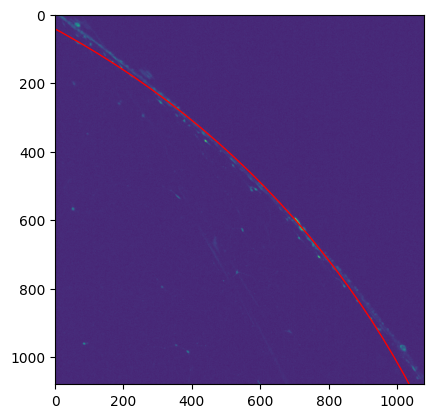

In [ ]:
%matplotlib inline

fig, ax = plt.subplots()
ax.imshow(img_stack[0])
circle1 = plt.Circle(( -1206 , 2278), 2541.38565, color='r', fill=False)
ax.add_patch(circle1)
plt.show()


In [ ]:

in_dir = "/home/brian/data4/brian/PBnJ/smart_paired_h5s/unpadded"
out_dir = "/home/brian/data4/brian/PBnJ/smart_paired_h5s/double_padded/train"

padding = np.array([[0,0],[0,0],[1,1]])

with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w-') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w-') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lmv[prob][:]
            neg_ones = labs < 0
            labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s

            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)



with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w-') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w-') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lfx[prob][:]
            neg_ones = labs < 0
            labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s
            
            oifx.create_dataset(prob, data = img)
            olfx.create_dataset(prob, data = labs)
